In [1]:
import glob
from SSIM_PIL import compare_ssim
from PIL import Image
import pandas as pd
from timeit import default_timer as timer
from tqdm.notebook import tqdm
from statistics import mean
import matplotlib.pyplot as plt
import imagehash
from torch import nn
from torchvision import transforms
from efficientnet_pytorch import EfficientNet
import numpy as np
import os
import re
from scipy.spatial import distance

In [2]:
# Read the filenames
fruits360_dataset = glob.glob("Dataset/fruits360/fruits-360-original-size/fruits-360-original-size/Test/*")
# Sort according to image numbers
fruits360_dataset.sort()

fruits360_dataset_subset = []
image_counter = 0
for folder in fruits360_dataset:
    folder_subset = glob.glob(folder+"/*")
    folder_subset.sort(key=lambda x:[int(c) if c.isdigit() else c for c in re.split(r'(\d+)', x)])
    folder_subset = folder_subset[:4]
    fruits360_dataset_subset.extend(folder_subset)
    image_counter += 1

# The dataframe rows are all the dataset images
dataset_rows = fruits360_dataset_subset
# the dataframe column is every 4th image in the dataset (refernece images)
dataset_columns = [filename for i, filename in enumerate(fruits360_dataset_subset) if i%4 == 0]

# Build the dataframe
df = pd.DataFrame(columns = dataset_columns, index = dataset_rows)

In [3]:
def linalg_norm(features1, features2):
    return round(np.linalg.norm(np.array(features1.detach()) - np.array(features2.detach())), 4)

def scipy_euc(features1, features2):
    return round(distance.euclidean(np.array(features1.detach()).flatten(),np.array(features2.detach()).flatten()), 4)

In [4]:
def compute_similarity(df, method, func, visualize=False):
    
    # Load the model and set it to evaluation mode
    if method.startswith("efficientnet"):
        model = EfficientNet.from_pretrained('efficientnet-b0')
    
    # Compare images
    time_list = []
    for r, row in enumerate(tqdm(df.index)):
        image1 = Image.open(row).convert('RGB')
        h1, w1 = image1.size
        image1 = image1.resize((150,150)) # to ease the computataion process
        for c, column in enumerate(tqdm(df.columns, leave=False)):
            if column != row: # so we dont compare the image to itself
                image2 = Image.open(column).convert('RGB')
                image2 = image2.resize((150,150)) # to ease the computataion process
                start_time = timer()

                if method == "SSIM" or method == "ssim":
                #  Compare images using CPU-only version
                    value = round(compare_ssim(image1, image2, GPU=False),4)
                    
                elif method == "average-hash":
                    hash1 = imagehash.average_hash(image1)
                    hash2 = imagehash.average_hash(image2)
                    value = round(hash1-hash2, 4)   
                    
                elif method == "cosine-similarity":
                    image1_tensor = transforms.ToTensor()(image1).reshape(1, -1).squeeze()
                    image2_tensor = transforms.ToTensor()(image2).reshape(1, -1).squeeze()
                    cos = nn.CosineSimilarity(dim=0)
                    value = round(float(cos(image1_tensor, image2_tensor)),4)
                    
                elif method == "efficientnet-b0-cosine-similarity":
                    image1_tensor = transforms.ToTensor()(image1)
                    image2_tensor = transforms.ToTensor()(image2)
                    features1 = model.extract_features(image1_tensor.unsqueeze(0))
                    features2 = model.extract_features(image2_tensor.unsqueeze(0))
                    cos = nn.CosineSimilarity(dim=0)
                    value = round(float(cos(features1.reshape(1, -1).squeeze(), features2.reshape(1, -1).squeeze())),4)
                    
                elif method == "efficientnet-b0-euclidean-distance":
                    image1_tensor = transforms.ToTensor()(image1)
                    image2_tensor = transforms.ToTensor()(image2)
                    features1 = model.extract_features(image1_tensor.unsqueeze(0))
                    features2 = model.extract_features(image2_tensor.unsqueeze(0))
                    
                    # Function as argument
                    value = func(features1, features2)

                elif method == "euclidean-distance":
                    value = round(np.linalg.norm(np.array(image1) - np.array(image2)), 4)
                    
                end_time = timer()
                elapsed_time = end_time - start_time
                time_list.append(elapsed_time) # Append the time to a list to later get the average
                df.loc[row, column] = value
                image2.close()
        image1.close()
        
    # Average running time
    avg_time = round(mean(time_list),4)
    
    # Pick highes 3 scores
    if method == 'average-hash' or method == "efficientnet-b0-euclidean-distance" \
    or method == "euclidean-distance":
        df = df.fillna(np.inf) # To neglect the reference images
    else:
        df = df.fillna(0) # To neglect the reference images
    similar_images_dict = {}
    
    if method == 'average-hash' or method == "efficientnet-b0-euclidean-distance" \
    or method == "euclidean-distance" :
        for column in df.columns:
            similar_images_dict[column] = list(df.nsmallest(n=3, columns=column)[column].index)
    else:
        for column in df.columns:
            similar_images_dict[column] = list(df.nlargest(n=3, columns=column)[column].index)
    
    # Plot
    if visualize == True:
        _, axs = plt.subplots(24, 4, figsize=(12, 40))
        axs = axs.flatten()
        i = 0
        j = 1
        for key, values in similar_images_dict.items():
            axs[i].imshow(Image.open(key))
            axs[i].title.set_text("reference")

            for value in values:
                axs[i+j].imshow(Image.open(value))
                axs[i+j].title.set_text(df.loc[value][key])
                i = i+j
            i += 1
        plt.show()
    
    # Compute accuracy
    # If you want to use your dataset, you have to follow the same naming convention so 
    # the accuracy can be calculated
    positive_predictions = 0
    for k,values in similar_images_dict.items():
        for v in values:
            if k.split("/")[-2] == v.split("/")[-2]:
                positive_predictions += 1
    final_accuracy = round(positive_predictions/(len(df)-len(df.columns))*100, 4)
    print(f"The accuracy using {method} is {final_accuracy}, average computing time: {avg_time}")
    
    return final_accuracy, avg_time

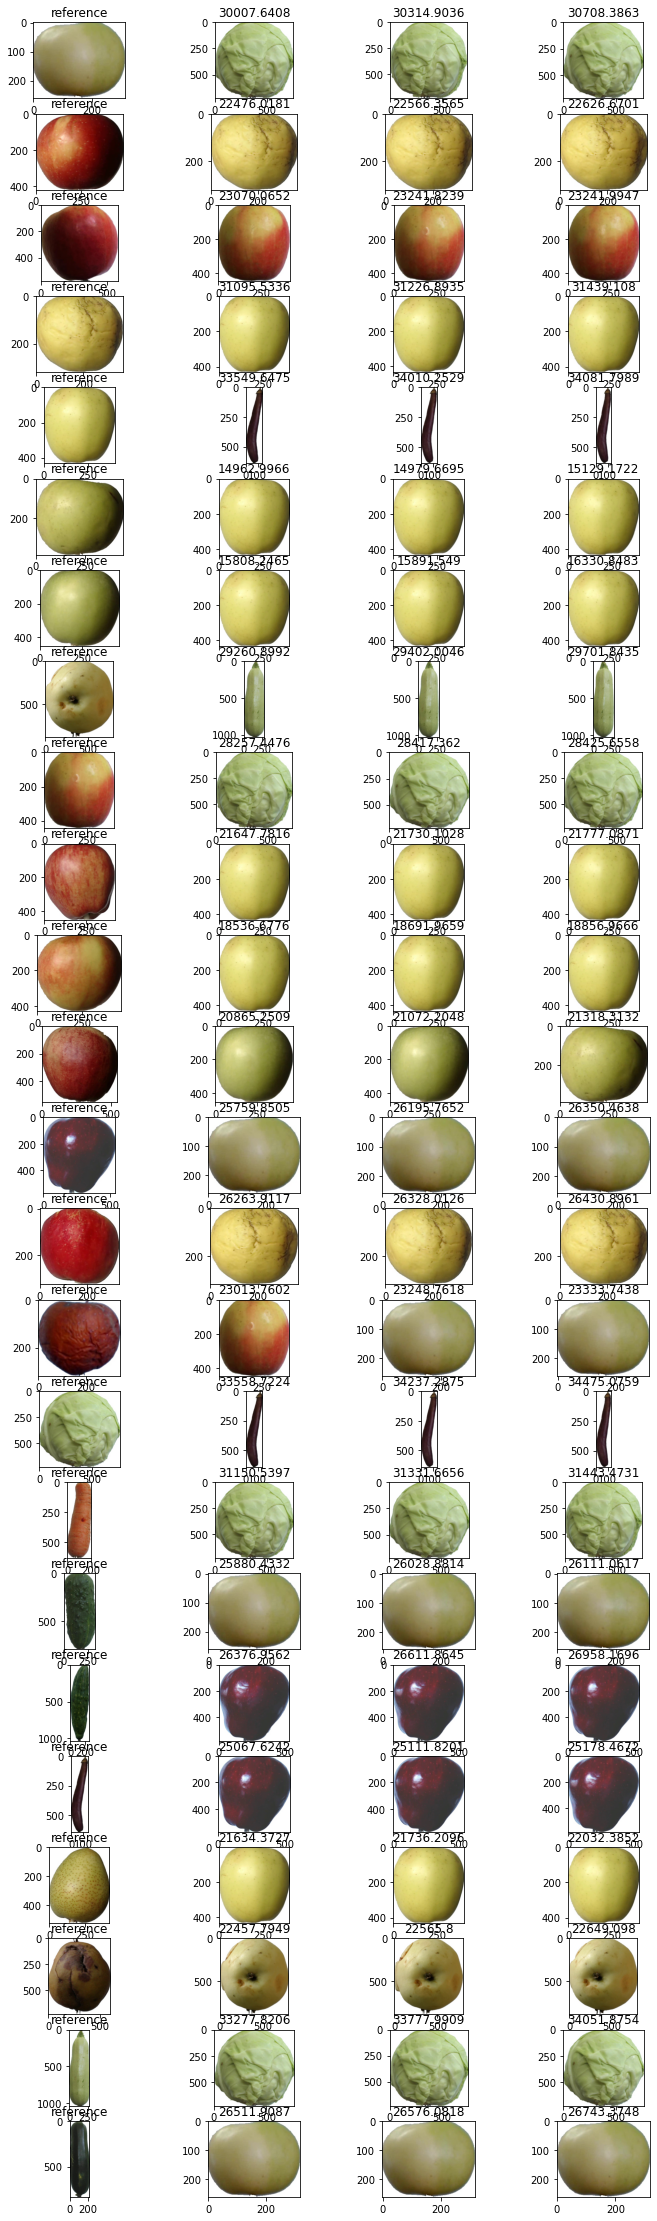

The accuracy using euclidean-distance is 0.0, average computing time: 0.0002


In [5]:
euclidean_acc, euclidean_speed = compute_similarity(df, "euclidean-distance", linalg_norm, visualize=True)

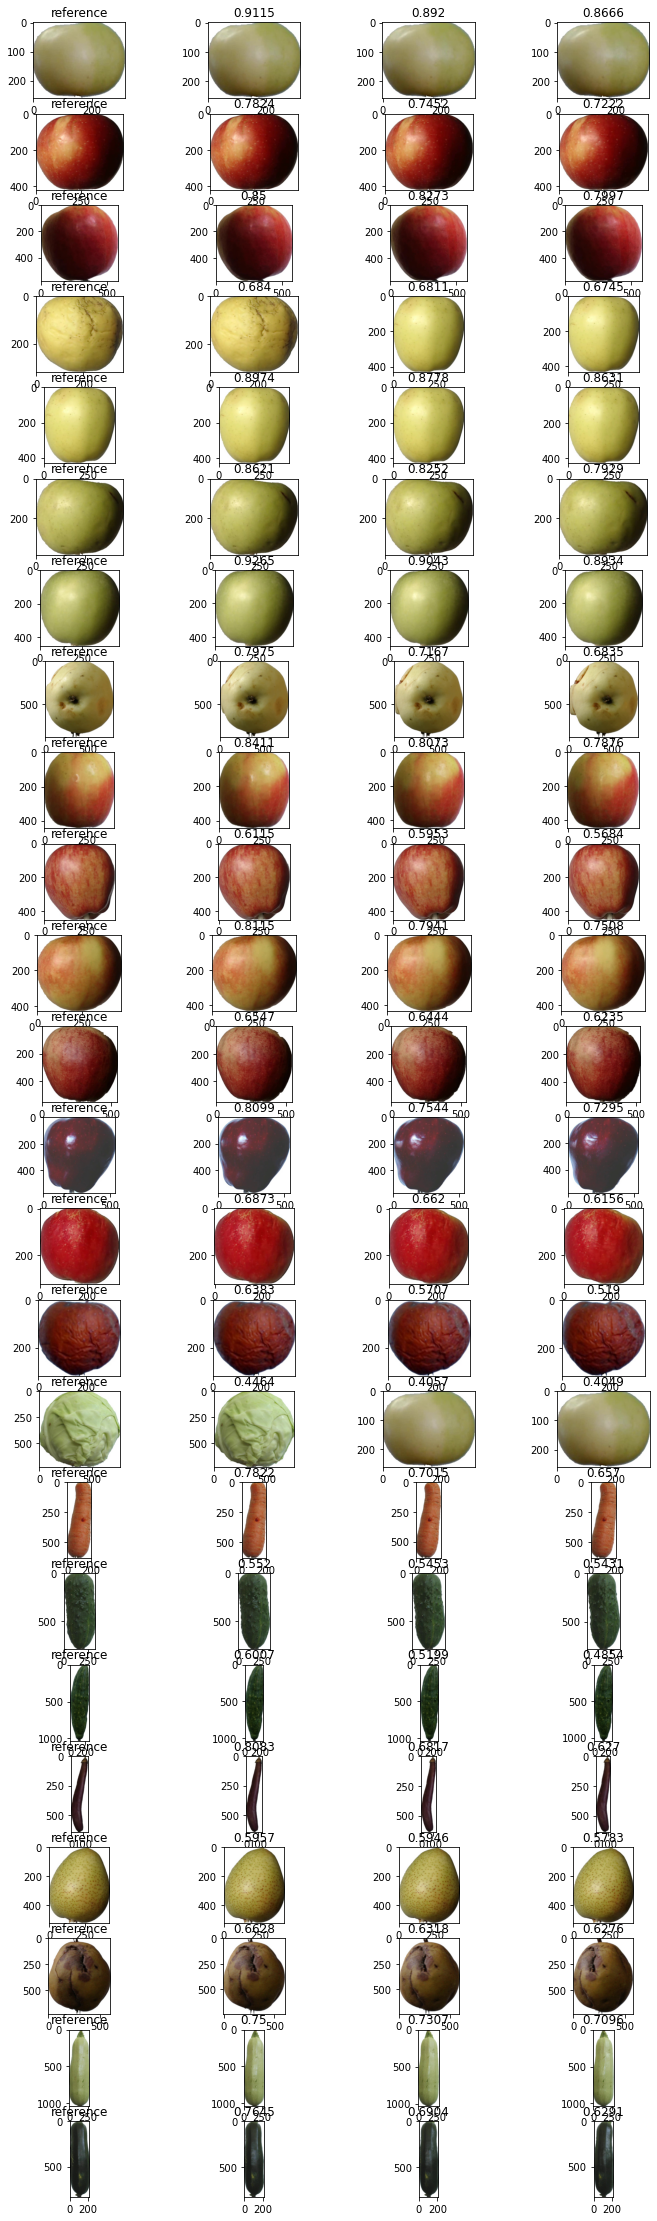

The accuracy using SSIM is 94.4444, average computing time: 0.0413


In [95]:
SSIM_acc, SSIM_speed = compute_similarity(df, "SSIM", linalg_norm, visualize=True)

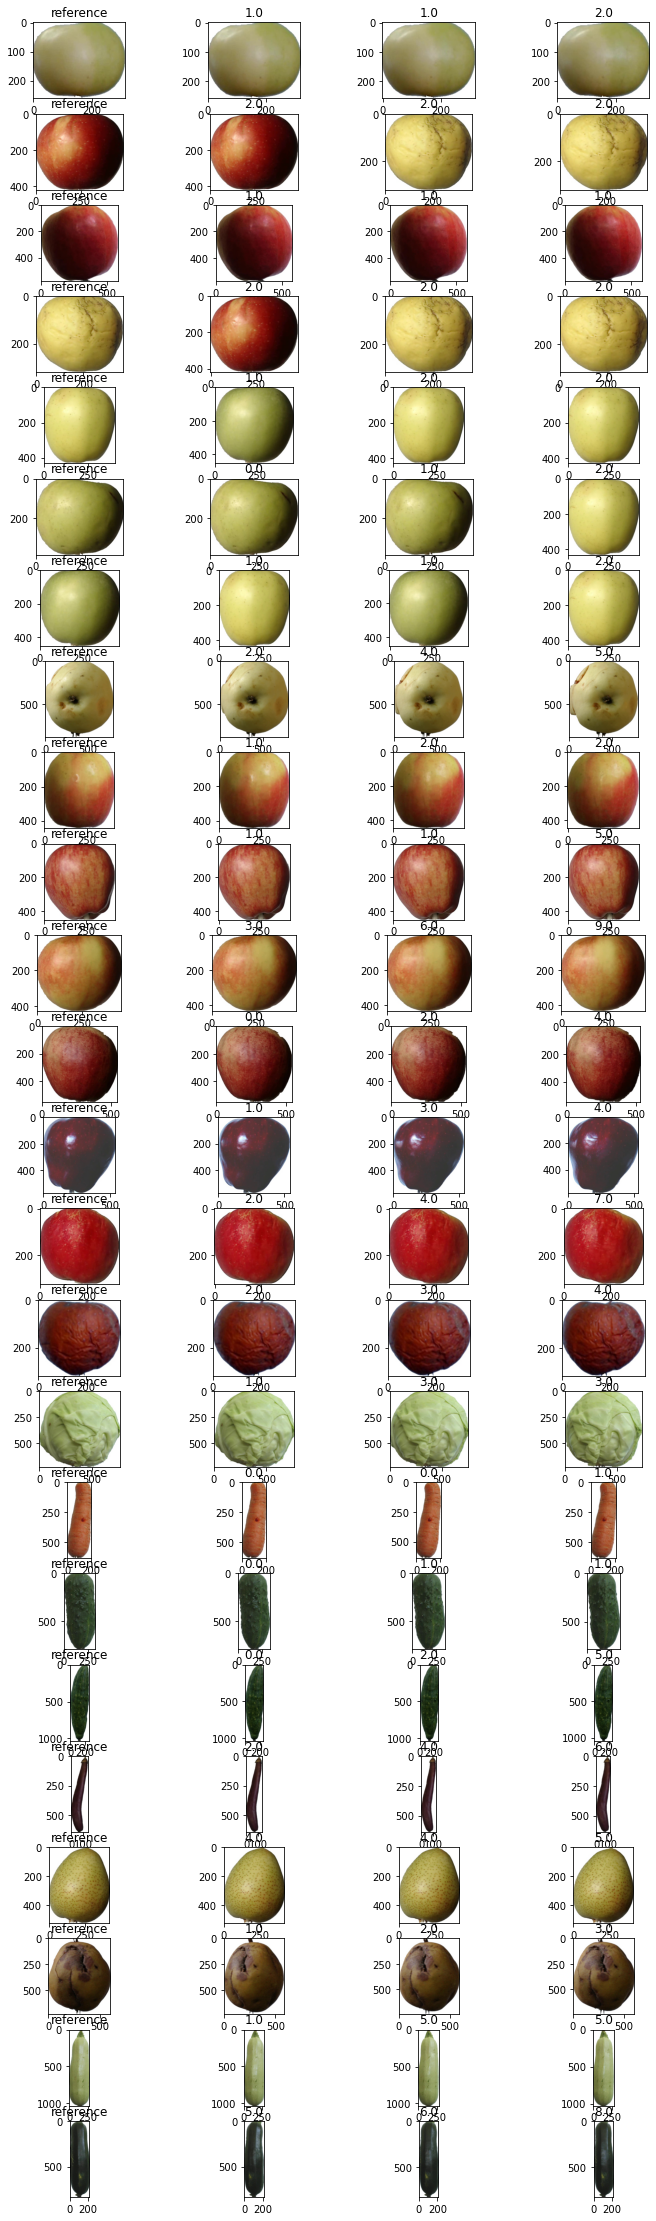

The accuracy using average-hash is 90.2778, average computing time: 0.0005


In [96]:
average_hash_acc, average_hash_speed = compute_similarity(df, "average-hash", linalg_norm, visualize=True)

In [97]:
cosine_similarity_acc, cosine_similarity_speed = compute_similarity(df, "cosine-similarity", linalg_norm, visualize=False)


The accuracy using cosine-similarity is 100.0, average computing time: 0.001


Loaded pretrained weights for efficientnet-b0


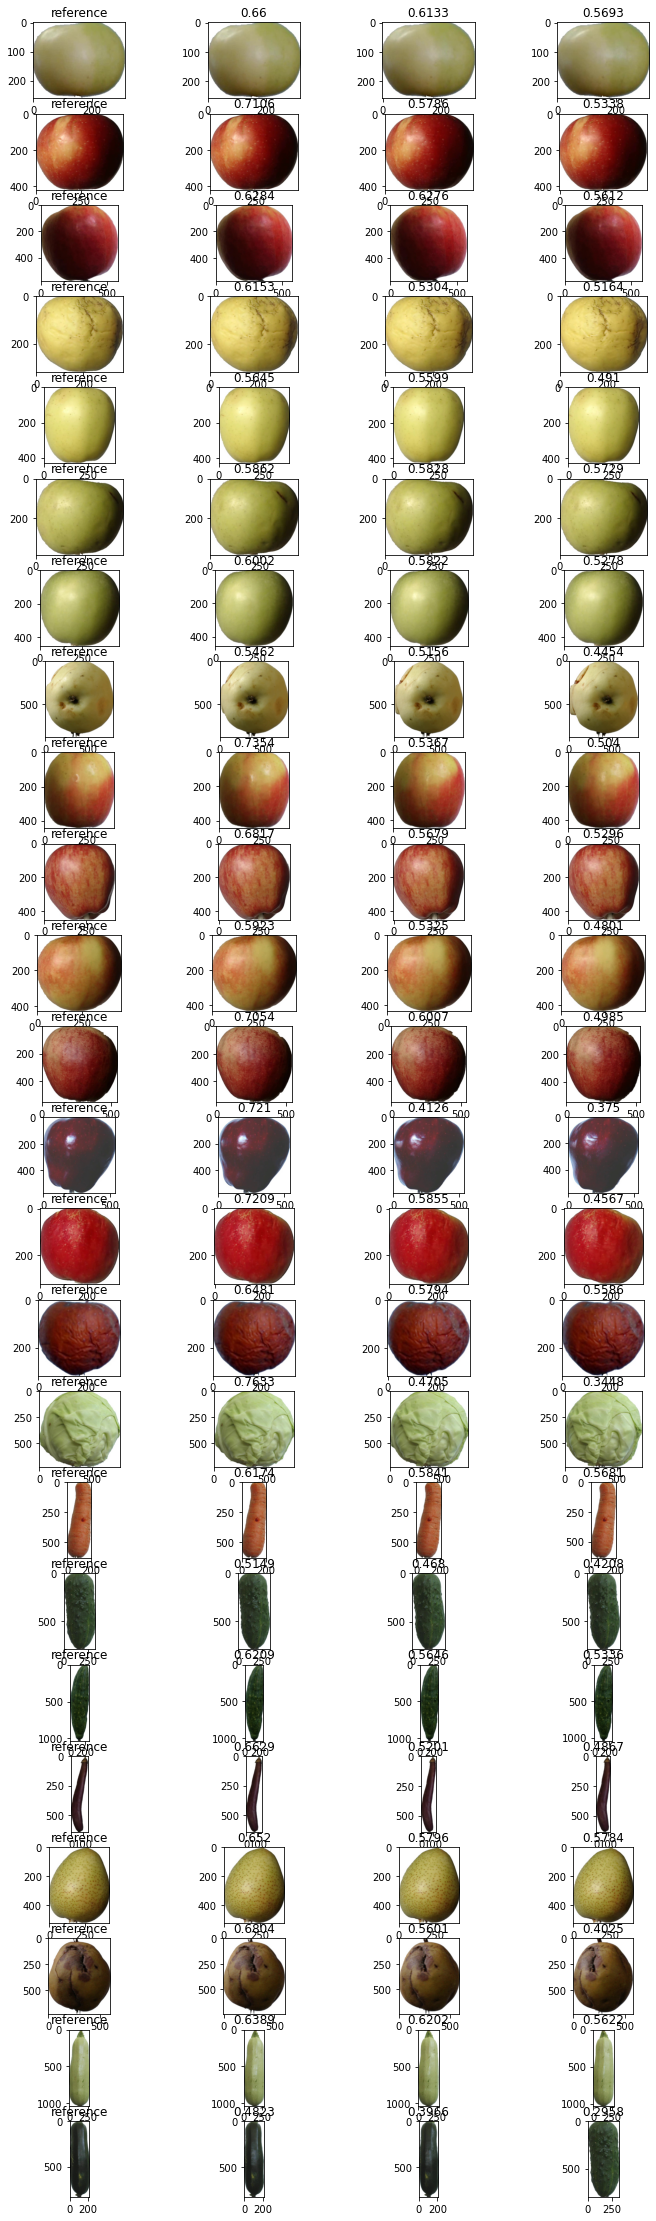

The accuracy using efficientnet-b0-cosine-similarity is 98.6111, average computing time: 0.2417


In [98]:
effnet_acc, effnet_speed = compute_similarity(df, "efficientnet-b0-cosine-similarity", linalg_norm, visualize=True)

# scipy

Loaded pretrained weights for efficientnet-b0


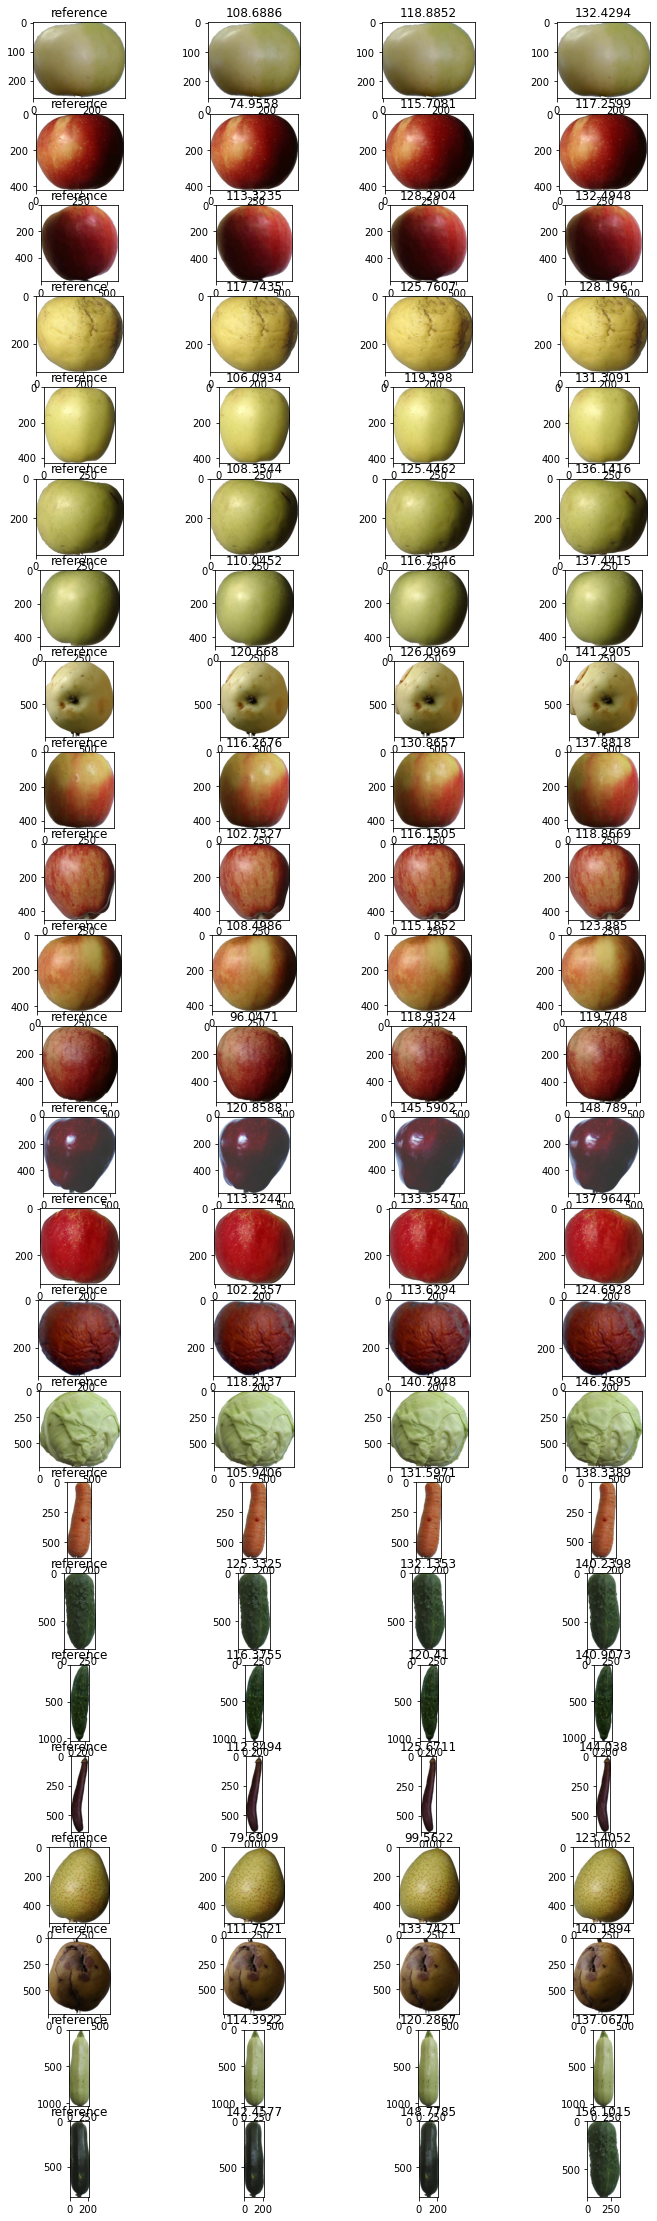

The accuracy using efficientnet-b0-euclidean-distance is 98.6111, average computing time: 0.2497


In [104]:
effnet_euc_acc, effnet_euc_speed = compute_similarity(df, "efficientnet-b0-euclidean-distance", scipy_euc, visualize=True)

# linalg.norm

Loaded pretrained weights for efficientnet-b0


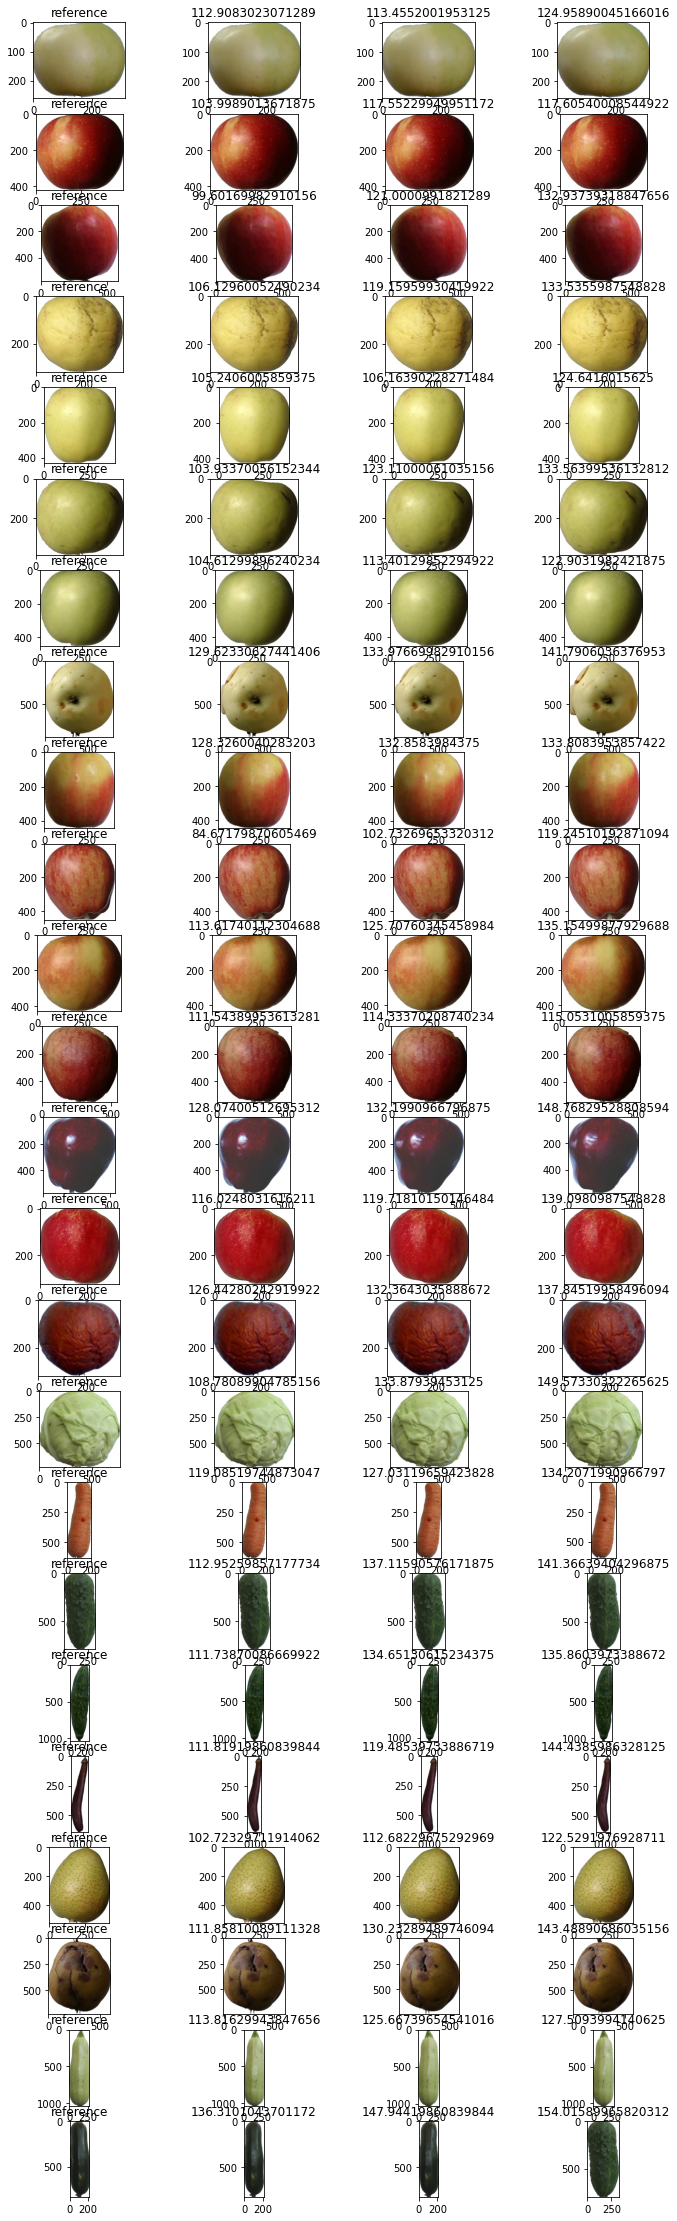

The accuracy using efficientnet-b0-euclidean-distance is 98.6111, average computing time: 0.2513


In [105]:
effnet_euc_acc, effnet_euc_speed = compute_similarity(df, "efficientnet-b0-euclidean-distance", linalg_norm, visualize=True)